# DS340W Modified Implementation

### Importing the required packages and reading the file.

In [17]:
import pandas as pd
import numpy as np

data = pd.read_csv('C:\\Users\\User\\OneDrive\\Desktop\\340\\input_file_1_sub.csv', sep = ',', index_col=0)
print('file shape', data.shape)

file shape (5000, 6)


## Data Cleaning

### Parsing column to date format

In [18]:
data['issue_d'] = pd.to_datetime(data['issue_d'])

### Check for and remove datapoints with null values.

In [19]:
print(data['issue_d'].isnull().any(), data['purpose'].isnull().any())

data = data.loc[data['purpose'].isnull() == False]


False False


### eliminate purpose categories with low count.

In [20]:
threshold = 8

counts = data['purpose'].value_counts()

keep_list = counts[counts > threshold].index

data = data[data['purpose'].isin(keep_list)]

### replace the existing labels so that they can be called easily from pandas and TensorFlow

In [21]:
to_replace = {
    'Debt consolidation': 'debt_consolidation',
    'Home improvement': 'home_improvement',
    'Credit card refinancing': 'credit_card',
    'Other': 'other',
    'Vacation': 'vacation',
    'Medical expenses': 'medical',
    'Car financing': 'car',
    'Major purchase': 'major_purchase',
    'Moving and relocation': 'moving',
    'Home buying': 'house'
}

data['purpose'] = data['purpose'].replace(to_replace)

print(data['purpose'].value_counts())

debt_consolidation    2532
other                  815
credit_card            545
home_improvement       268
car                    177
major_purchase         162
moving                 133
medical                124
vacation                77
small_business          62
house                   56
Business                12
Name: purpose, dtype: int64


# Replicating the Parent Code

### Create one-hot encoded dummy columns for categorical variables.


In [22]:
data = pd.get_dummies(data, columns=['purpose'], drop_first=False)
print('data columns AFTER hot encoding      ', data.columns)

data columns AFTER hot encoding       Index(['dti', 'emp_length', 'issue_d', 'loan_amnt', 'rejected',
       'purpose_Business', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation'],
      dtype='object')


### split training and test data by date quantile.

In [23]:
data_train = data.loc[data['issue_d'] < data['issue_d'].quantile(0.9)]
data_test = data.loc[data['issue_d'] >= data['issue_d'].quantile(0.9)]

print('Number of loans in the partition:   ', data_train.shape[0] + data_test.shape[0])
print('Number of loans in the full dataset:', data.shape[0])


Number of loans in the partition:    4963
Number of loans in the full dataset: 4963


### Drop the date column as not needed for the model.

In [24]:
data_train.drop('issue_d', axis=1, inplace=True)
data_test.drop('issue_d', axis=1, inplace=True)

F:\New folder\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Split features and labels 

In [25]:
y_train = data_train['rejected']
y_test = data_test['rejected']
X_train = data_train.drop('rejected', axis=1)
X_test = data_test.drop('rejected', axis=1)

# Check if y_train contains more than one unique class label
if len(np.unique(y_train)) > 1:
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, PolynomialFeatures
    from sklearn.impute import SimpleImputer
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import SGDClassifier

    '''Build a pipeline for preprocessing and training'''
    pipeline_sgdlogreg = Pipeline([
        ('imputer',  SimpleImputer(copy=False)), # Mean imputation by default
        ('scaler', StandardScaler(copy=False)),
        ('model', SGDClassifier(
            class_weight='balanced',
            loss='log_loss',
            max_iter=1000,
            tol = 1e-3,
            random_state=1,
            n_jobs=10,
            warm_start=True
            )
        )
    ])

    param_grid_sgdlogreg = {
        'model__alpha': [10**-3, 10**-2, 10**1],
        'model__penalty': ['l1', 'l2']
    }

    '''Set up a grid search.'''
    grid_sgdlogreg = GridSearchCV(
        estimator=pipeline_sgdlogreg,
        param_grid=param_grid_sgdlogreg,
        scoring='roc_auc',
        pre_dispatch=3,
        n_jobs=5,
        cv=5,
        verbose=5,
        return_train_score=False
    )

    '''Fit the model.'''
    print('fitting')
    grid_sgdlogreg.fit(X_train, y_train)

    '''Print model parameters, best parameters and best score.'''
    print('parameters       ', grid_sgdlogreg.get_params())
    print(grid_sgdlogreg.best_params_, grid_sgdlogreg.best_score_)

    from sklearn.metrics import roc_auc_score, recall_score

    '''Make predictions on test dataset.'''
    y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
    y_score_flag = [int(round(i)) for i in y_score]

    print('LOOK FOR DISCREPANCIES HERE...')
    print(roc_auc_score(y_test, y_score), recall_score(y_test, y_score_flag, pos_label=1), recall_score(y_test, y_score_flag, pos_label=0))

    y_score_flag = grid_sgdlogreg.predict(X_test)
else:
    print("y_train contains only one unique class label. Unable to fit the model.")

fitting
Fitting 5 folds for each of 6 candidates, totalling 30 fits
parameters        {'cv': 5, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('imputer', SimpleImputer(copy=False)), ('scaler', StandardScaler(copy=False)), ('model', SGDClassifier(class_weight='balanced', loss='log_loss', n_jobs=10,
              random_state=1, warm_start=True))], 'estimator__verbose': False, 'estimator__imputer': SimpleImputer(copy=False), 'estimator__scaler': StandardScaler(copy=False), 'estimator__model': SGDClassifier(class_weight='balanced', loss='log_loss', n_jobs=10,
              random_state=1, warm_start=True), 'estimator__imputer__add_indicator': False, 'estimator__imputer__copy': False, 'estimator__imputer__fill_value': None, 'estimator__imputer__keep_empty_features': False, 'estimator__imputer__missing_values': nan, 'estimator__imputer__strategy': 'mean', 'estimator__scaler__copy': False, 'estimator__scaler__with_mean': True, 'estimator__scaler__with_std': True, 'estim

#### ROC AUC score is 0.519
#### Recall for Rejected Loans (Positive Class): 0.702
#### Recall for Accepted Loans (Negative Class): 0.315

# Our approach

### Linear Regression Model

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

X_train = X_train.dropna()
y_train = y_train[X_train.index]

X_test = X_test.dropna()
y_test = y_test[X_test.index]

lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

print('Coefficients: \n', lm.coef_)

Coefficients: 
 [ 2.09844123e-04  4.93230558e-04  5.27304970e-07  3.44078533e-03
 -1.35124482e-02 -2.13590976e-02 -5.42427517e-03  5.11026652e-03
  4.16926736e-02  1.45512851e-03  2.88751931e-03  3.19148717e-02
 -2.51540668e-02  2.63475978e-02 -4.73989550e-02]


In [27]:
len(X_train)

4113

In [28]:
from sklearn.metrics import r2_score, recall_score, roc_auc_score, confusion_matrix


r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')


y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

recall = recall_score(y_test, y_pred_binary)
print(f'Recall: {recall}')

roc_auc = roc_auc_score(y_test, y_pred_binary)
print(f'ROC AUC Score: {roc_auc}')

cm = confusion_matrix(y_test, y_pred_binary)
recall_rejected = cm[1,1] / (cm[1,1] + cm[1,0])
recall_accepted = cm[0,0] / (cm[0,0] + cm[0,1])
print(f'Recall for Rejected Loans: {recall_rejected}')
print(f'Recall for Accepted Loans: {recall_accepted}')

R^2 Score: -0.018473564933230602
Recall: 1.0
ROC AUC Score: 0.5
Recall for Rejected Loans: 1.0
Recall for Accepted Loans: 0.0


In [29]:
percentage = data['rejected'].value_counts(normalize=True) * 100

print(percentage)

1    86.802337
0    13.197663
Name: rejected, dtype: float64


### PolynomialFeatures Model

In [30]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()
lm_poly.fit(X_train_poly, y_train)


y_pred_poly = lm_poly.predict(X_test_poly)



print('Coefficients (Polynomial Regression): \n', lm_poly.coef_)

r2_poly = r2_score(y_test, y_pred_poly)
recall_poly = recall_score(y_test, [1 if p > 0.2 else 0 for p in y_pred_poly])
roc_auc_poly = roc_auc_score(y_test, [1 if p > 0.2 else 0 for p in y_pred_poly])
cm_poly = confusion_matrix(y_test, [1 if p > 0.2 else 0 for p in y_pred_poly])
recall_rejected_poly = cm_poly[1,1] / (cm_poly[1,1] + cm_poly[1,0])
recall_accepted_poly = cm_poly[0,0] / (cm_poly[0,0] + cm_poly[0,1])

print(f'R^2 (Polynomial Regression): {r2_poly}')
print(f'Recall (Polynomial Regression): {recall_poly}')
print(f'ROC AUC Score (Polynomial Regression): {roc_auc_poly}')
print(f'Recall for Rejected Loans (Polynomial Regression): {recall_rejected_poly}')
print(f'Recall for Accepted Loans (Polynomial Regression): {recall_accepted_poly}')

Coefficients (Polynomial Regression): 
 [-5.05702919e-09 -3.40875700e-04  4.66780244e-03  1.25661675e-06
  1.10695644e-01 -3.14662667e-02  1.65383737e-02 -2.26144751e-02
 -4.13115515e-02  6.91162552e-02 -2.82191596e-02 -2.41754712e-02
 -1.64438669e-02 -2.53666200e-02  5.35038610e-03 -1.21032621e-02
 -7.83490121e-06  7.88137263e-05  2.30593314e-08 -8.26648995e-03
  9.22299328e-04 -5.27657503e-04  1.11886415e-03  2.01594564e-03
 -2.01658828e-03  2.34881263e-03  1.95965369e-03  1.10034572e-03
  9.25299594e-04 -2.56323113e-04  3.34926159e-04 -1.87553683e-03
  2.63074124e-07 -1.67658538e-02  1.75053213e-02  4.67368334e-05
 -1.13188720e-03  7.85848694e-03 -1.12690117e-02  2.06365343e-02
 -1.95467748e-02  1.68966115e-02  8.71876697e-03 -1.86421466e-03
 -1.64169134e-02 -3.50991737e-11 -2.87732528e-06 -7.00081386e-07
 -3.31826840e-06  1.58690371e-07  2.15430683e-06 -2.65262500e-06
 -1.06198355e-06  5.28300879e-06  3.06777264e-06 -1.88766783e-06
  5.08955527e-07  2.58181467e-06  1.10695644e-01  

### Logistic Regression Model

In [31]:
from sklearn.linear_model import LogisticRegression 

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)


print('Coefficients (Logistic Regression): \n', logreg.coef_)

r2_log = r2_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
roc_auc_log = roc_auc_score(y_test, y_pred_log)
cm_log = confusion_matrix(y_test, y_pred_log)
recall_rejected_log = cm_log[1,1] / (cm_log[1,1] + cm_log[1,0])
recall_accepted_log = cm_log[0,0] / (cm_log[0,0] + cm_log[0,1])

print(f'R^2 (Logistic Regression): {r2_log}')
print(f'Recall (Logistic Regression): {recall_log}')
print(f'ROC AUC Score (Logistic Regression): {roc_auc_log}')
print(f'Recall for Rejected Loans (Logistic Regression): {recall_rejected_log}')
print(f'Recall for Accepted Loans (Logistic Regression): {recall_accepted_log}')

Coefficients (Logistic Regression): 
 [[ 1.96758702e-03  2.04880974e-02  6.85298276e-06  5.14616228e-04
   8.13558446e-02 -1.92173632e-03  5.19723716e-01  1.05949505e-01
   1.83946125e-02  9.44011837e-02  9.51252165e-02  1.30786948e-01
   3.33693181e-01  3.04282380e-02  2.37863331e-02]]
R^2 (Logistic Regression): -0.22717622080679423
Recall (Logistic Regression): 1.0
ROC AUC Score (Logistic Regression): 0.5
Recall for Rejected Loans (Logistic Regression): 1.0
Recall for Accepted Loans (Logistic Regression): 0.0


#### Correlation Matrix

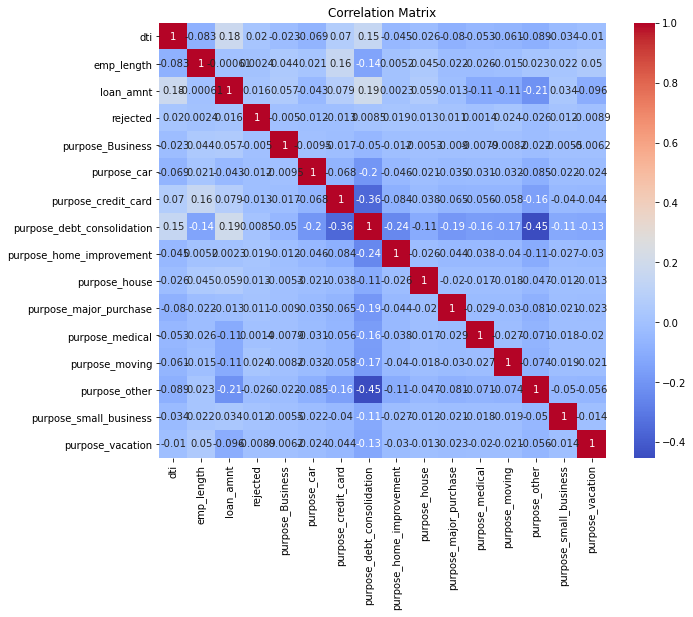

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


#### Histogram of loan amounts for rejected and accepted loans


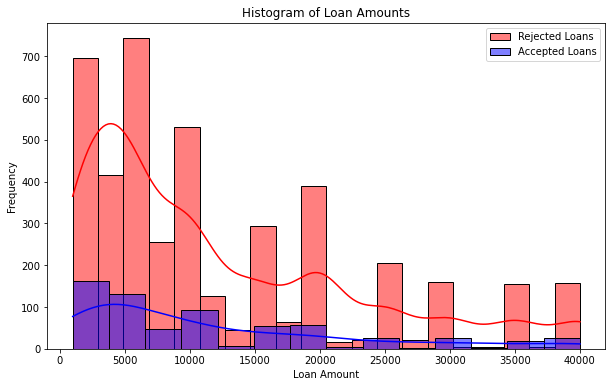

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(data[data['rejected'] == 1]['loan_amnt'], color='red', kde=True, label='Rejected Loans')
sns.histplot(data[data['rejected'] == 0]['loan_amnt'], color='blue', kde=True, label='Accepted Loans')
plt.title('Histogram of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Boxplot of dti for rejected and accepted loans

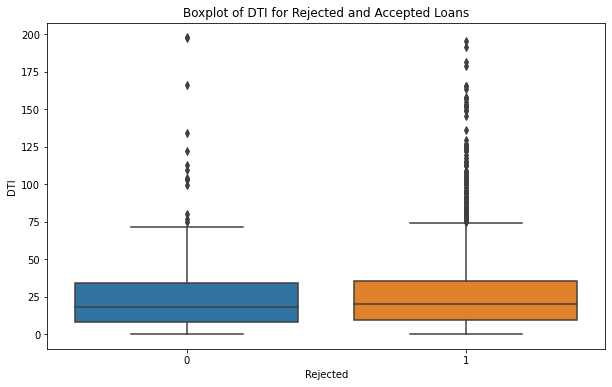

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='rejected', y='dti', data=data)
plt.title('Boxplot of DTI for Rejected and Accepted Loans')
plt.xlabel('Rejected')
plt.ylabel('DTI')
plt.show()


### Xgboost Model

In [35]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

In [36]:
print('Feature importances (XGBoost): \n', xgb_model.feature_importances_)

r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'R^2 (XGBoost): {r2_xgb}')

Feature importances (XGBoost): 
 [0.08181645 0.08316047 0.07589166 0.01231259 0.09031513 0.07868122
 0.08367105 0.07673382 0.0433135  0.08210454 0.04963794 0.04813321
 0.08025777 0.06833081 0.04563991]
R^2 (XGBoost): -0.29598984066511913


In [37]:
recall_xgb = recall_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
recall_rejected_xgb = cm_xgb[1,1] / (cm_xgb[1,1] + cm_xgb[1,0])
recall_accepted_xgb = cm_xgb[0,0] / (cm_xgb[0,0] + cm_xgb[0,1])

print(f'Recall (XGBoost): {recall_xgb}')
print(f'ROC AUC Score (XGBoost): {roc_auc_xgb}')
print(f'Recall for Rejected Loans (XGBoost): {recall_rejected_xgb}')
print(f'Recall for Accepted Loans (XGBoost): {recall_accepted_xgb}')

Recall (XGBoost): 0.9787685774946921
ROC AUC Score (XGBoost): 0.5080758775323928
Recall for Rejected Loans (XGBoost): 0.9787685774946921
Recall for Accepted Loans (XGBoost): 0.037383177570093455


### Random Forest Model

In [38]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
print(f'R^2 (RandomForset): {r2_rf}')

recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
recall_rejected_rf = cm_rf[1,1] / (cm_rf[1,1] + cm_rf[1,0])
recall_accepted_rf = cm_rf[0,0] / (cm_rf[0,0] + cm_rf[0,1])

print(f'Recall (Random Forest): {recall_rf}')
print(f'ROC AUC Score (Random Forest): {roc_auc_rf}')
print(f'Recall for Rejected Loans (Random Forest): {recall_rejected_rf}')
print(f'Recall for Accepted Loans (Random Forest): {recall_accepted_rf}')

R^2 (RandomForset): -0.5253685735262021
Recall (Random Forest): 0.9299363057324841
ROC AUC Score (Random Forest): 0.4976784332400739
Recall for Rejected Loans (Random Forest): 0.9299363057324841
Recall for Accepted Loans (Random Forest): 0.06542056074766354


### Gradient Boosting Model

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
print(f'R^2 (Gradient Boost): {r2_gb}')

recall_gb = recall_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_gb)
cm_gb = confusion_matrix(y_test, y_pred_gb)
recall_rejected_gb = cm_gb[1,1] / (cm_gb[1,1] + cm_gb[1,0])
recall_accepted_gb = cm_gb[0,0] / (cm_gb[0,0] + cm_gb[0,1])

print(f'Recall (Gradient Boost): {recall_gb}')
print(f'ROC AUC Score (Gradient Boost): {roc_auc_gb}')
print(f'Recall for Rejected Loans (Gradient Boost): {recall_rejected_gb}')
print(f'Recall for Accepted Loans (Gradient Boost): {recall_accepted_gb}')

R^2 (Gradient Boost): -0.2386451574498485
Recall (Gradient Boost): 0.9978768577494692
ROC AUC Score (Gradient Boost): 0.4989384288747346
Recall for Rejected Loans (Gradient Boost): 0.9978768577494692
Recall for Accepted Loans (Gradient Boost): 0.0


### Stacked Model

In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
# 
base_models = [('Random Forest', rf),
               ('Gradient Boosting', gb),
               ('XGBoost', xgb_model)]

final_model = LogisticRegression()

stacking = StackingClassifier(estimators=base_models, final_estimator=final_model)

stacking.fit(X_train, y_train)

y_pred_stacking = stacking.predict(X_test)


r2_stacking = r2_score(y_test, y_pred_stacking)
print(f'R^2 (stacking): {r2_stacking}')

recall_stacking = recall_score(y_test, y_pred_stacking)/
roc_auc_stacking = roc_auc_score(y_test, y_pred_stacking)
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
recall_rejected_stacking = cm_stacking[1,1] / (cm_stacking[1,1] + cm_stacking[1,0])
recall_accepted_stacking = cm_stacking[0,0] / (cm_stacking[0,0] + cm_stacking[0,1])

print(f'Recall (stacking): {recall_stacking}')
print(f'ROC AUC Score (stacking): {roc_auc_stacking}')
print(f'Recall for Rejected Loans (stacking): {recall_rejected_stacking}')
print(f'Recall for Accepted Loans (stacking): {recall_accepted_stacking}')

R^2 (stacking): -0.22717622080679423
Recall (stacking): 1.0
ROC AUC Score (stacking): 0.5
Recall for Rejected Loans (stacking): 1.0
Recall for Accepted Loans (stacking): 0.0


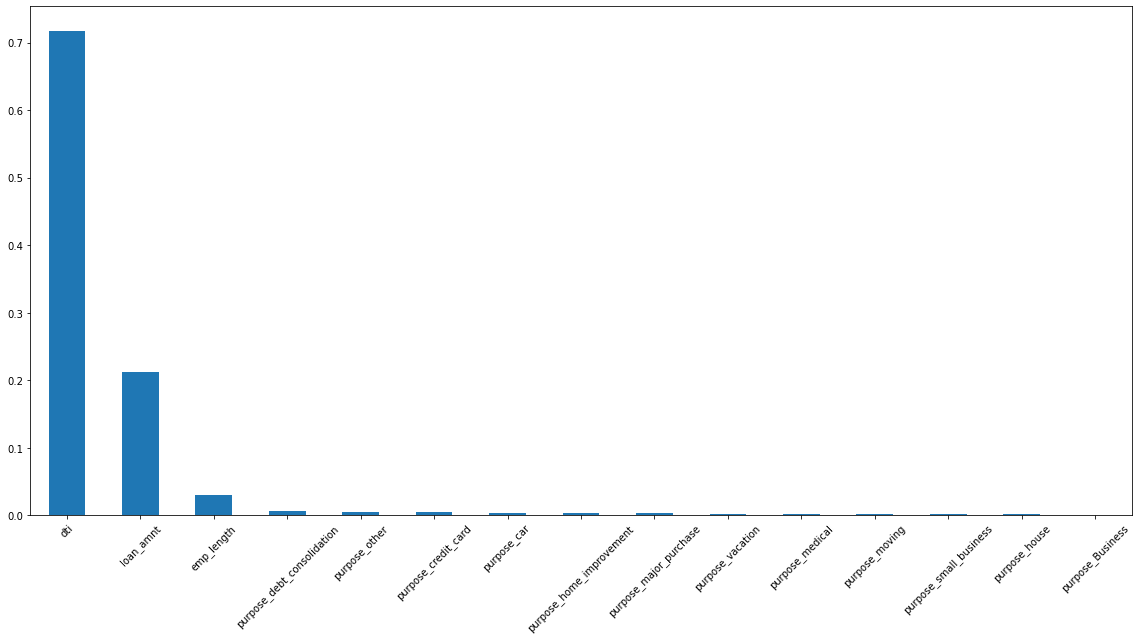

In [41]:
importances = rf.feature_importances_

f_importances = pd.Series(importances, X_train.columns)
f_importances.sort_values(ascending=False, inplace=True)

f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45)
plt.tight_layout()
plt.show()